**Transferencia de aprendizaje aplicado a perros y gatos\**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import os
# Ver qué hay en tu Drive
print(os.listdir('/content/drive/MyDrive/'))

['Classroom', 'GUIA_EXCOBA.pdf', 'CERTIFICADO_427740.pdf', 'fisicaserway_Vol1.pdf', 'Tarea 1.pdf', 'Práctica 5.pdf', 'Conceptos de física que considero importantes.pdf', 'comprobanteVigenciaDerechos46220438819 (1).pdf', 'comprobanteVigenciaDerechos46220438819 (2).pdf', 'Práctica 10 energía.pdf', 'Práctica 11 recipientes.pdf', 'Práctica 12 elementos de un circuito eléctico.pdf', 'Colab Notebooks', 'Práctica final.pdf', 'Jan 10, 1.26 PM\u200b.aac', 'Dancing with Qubits How quantum computing works and how it can change the world (Robert S. Sutor) (z-lib.org).pdf', 'Carátula IMSS.pdf', 'Jan 19, 7.16 PM\u200b.aac', 'Jan 29, 2.25 PM\u200b.aac', 'Feb 1, 3.11 PM\u200b.aac', 'INE_MAMA.pdf', 'INE_OscarR_Sánchez.pdf', 'Reporte 1.gdoc', 'Documento sin título (1).gdoc', 'Práctica 3 laboratorio de mecánica.gdoc', 'Práctica 4 laboratorio de mecánica..gdoc', 'Práctica 5 laboratorio de mecánica.gdoc', 'CERTIFICADO_BACHILLERATO.pdf', 'Pago_Constancia.pdf', 'CONSTANCIA DE ESTUDIOS (3).pd

In [6]:
# Verificamos la estructura del dataset

train_dir = '/content/drive/MyDrive/Train'

print("Verificando contenido de la carpeta Train:")
items = os.listdir(train_dir)
print(f"Total de items: {len(items)}\n")

# Mostrar primeros 10 items
for item in items[:10]:
    item_path = os.path.join(train_dir, item)
    if os.path.isdir(item_path):
        num_files = len(os.listdir(item_path))
        print(f"  📁 {item}: {num_files} archivos")
    else:
        print(f"  📄 {item}")

print("\n✓ Verificación completa")

Verificando contenido de la carpeta Train:
Total de items: 4340

  📄 dog.8984.jpg
  📄 cat.11502.jpg
  📄 dog.12346.jpg
  📄 cat.2055.jpg
  📄 dog.6765.jpg
  📄 cat.4430.jpg
  📄 dog.9456.jpg
  📄 dog.8990.jpg
  📄 cat.11516.jpg
  📄 cat.10608.jpg

✓ Verificación completa


In [7]:
# Copiar la carpeta Train de Drive a Colab
source = '/content/drive/MyDrive/Train'
destination = '/content/Train'

print("Copiando dataset a Colab (esto puede tardar unos minutos)...")
shutil.copytree(source, destination)
print(f"✓ Dataset copiado a {destination}")

# Ahora trabajamos con esta ruta local
train_dir = '/content/Train'

Copiando dataset a Colab (esto puede tardar unos minutos)...
✓ Dataset copiado a /content/Train


In [8]:
# PASO 3: Organizar imágenes en subcarpetas Cat y Dog

train_dir = '/content/Train'

# Crear carpetas Cat y Dog
cat_dir = os.path.join(train_dir, 'Cat')
dog_dir = os.path.join(train_dir, 'Dog')

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Mover imágenes según su nombre
cat_count = 0
dog_count = 0

for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)

    # Saltar si es una carpeta
    if os.path.isdir(file_path):
        continue

    # Mover según el prefijo del nombre
    if filename.lower().startswith('cat'):
        shutil.move(file_path, os.path.join(cat_dir, filename))
        cat_count += 1
    elif filename.lower().startswith('dog'):
        shutil.move(file_path, os.path.join(dog_dir, filename))
        dog_count += 1

print(f"Imágenes reorganizadas:")
print(f"  - Gatos: {cat_count} imágenes")
print(f"  - Perros: {dog_count} imágenes")

Imágenes reorganizadas:
  - Gatos: 2174 imágenes
  - Perros: 2166 imágenes


In [9]:
# Cargamos el dataset con Tensorflow
import tensorflow as tf

train_dir = '/content/Train'

# Parámetros
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Cargar dataset de entrenamiento (80%)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Cargar dataset de validación (20%)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Verificar las clases
class_names = train_dataset.class_names
print(f"\n✓ Clases detectadas: {class_names}")
print(f"✓ Batches de entrenamiento: {len(train_dataset)}")
print(f"✓ Batches de validación: {len(validation_dataset)}")

Found 4340 files belonging to 2 classes.
Using 3472 files for training.
Found 4340 files belonging to 2 classes.
Using 868 files for validation.

✓ Clases detectadas: ['Cat', 'Dog']
✓ Batches de entrenamiento: 109
✓ Batches de validación: 28


In [10]:
# Optimizar el rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

print("✓ Datasets optimizados y listos para entrenar")

✓ Datasets optimizados y listos para entrenar


In [11]:
# Creamos el MODELO BASE con Transfer Learning

#Definamos los parametros de entrada de las imagenes
IMG_SHAPE = IMG_SIZE + (3,)  # (160, 160, 3)

# Cargamos MobileNetV2 preentrenado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,  # No incluir las ultimas capas del modelo (las capas de clasificación)
    weights='imagenet'   # Cargamos los pesos preentrenados
)

# Congelamos el modelo base porque estos pesos ya son muy buenos para detectar características visuales. Solo entrenaremos las nuevas capas que agregaremos encima
base_model.trainable = False

print(f"✓ Modelo base: {base_model.name}")
print(f"  Capas totales: {len(base_model.layers)}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Modelo base: mobilenetv2_1.00_160
  Capas totales: 154


In [12]:
# 7- Construimos el modelo completo

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Construimos el modelo
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

print("\n Modelo completo construido dado por:")
model.summary()

print("Solo entrenamos el 0.06% del modelo (1,281 de 2.2 millones). Aprovechamos el 99.94% del conocimiento preentrenado. Por lo que el entrenamiento será rápido y eficiente")



 Modelo completo construido dado por:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Solo entrenamos el 0.06% del modelo (1,281 de 2.2 millones). Aprovechamos el 99.94% del conocimiento preentrenado. Por lo que el entrenamiento será rápido y eficiente


In [13]:
# 8 - Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✓ Modelo compilado y listo para entrenar")

✓ Modelo compilado y listo para entrenar


In [14]:
# 9- Entrenar el modelo básico
epochs = 10

print("Iniciando entrenamiento del modelo básico...")
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

print("\n Entrenamiento completado")

Iniciando entrenamiento del modelo básico...
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 101s 875ms/step - accuracy: 0.6167 - loss: 0.6900 - val_accuracy: 0.8698 - val_loss: 0.3917
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 94s 868ms/step - accuracy: 0.8693 - loss: 0.3664 - val_accuracy: 0.9355 - val_loss: 0.2508
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 93s 855ms/step - accuracy: 0.9231 - loss: 0.2458 - val_accuracy: 0.9562 - val_loss: 0.1879
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 137s 809ms/step - accuracy: 0.9494 - loss: 0.1860 - val_accuracy: 0.9654 - val_loss: 0.1536
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 90s 823ms/step - accuracy: 0.9595 - loss: 0.1510 - val_accuracy: 0.9677 - val_loss: 0.1327
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 90s 828ms/step - accuracy: 0.9613 - loss: 0.1308 - val_accuracy: 0.9712 - val_loss: 0.1185
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 100s 920ms/step - accuracy: 0.9718 - loss: 0.1144 - val_accuracy: 0.9735 - val_loss: 0.1083
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━

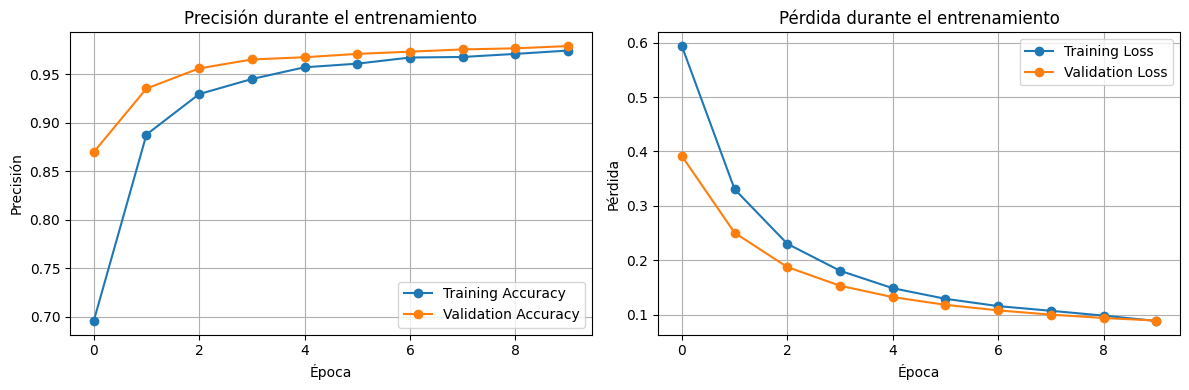


 Mejor Validation Accuracy: 0.9793 en época 10


In [15]:
#10- Visualizacion de los resultados del entrenamiento
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

# Gráfica de precisión
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.grid(True)

# Gráfica de pérdida
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)

plt.tight_layout()
plt.show()

# Mostrar el mejor resultado
best_val_acc = max(val_acc)
best_epoch = val_acc.index(best_val_acc) + 1
print(f"\n Mejor Validation Accuracy: {best_val_acc:.4f} en época {best_epoch}")